# Evaluation exercise for Google Summer of Code / ATLAS autoencoders

This notebook consists of pre-processing some ATLAS data, and then applying a deep autoencoder network to it.

## 1. Handling the Data


Since in this dataset, the relevant information is within the cells marked with j(jet particle), some clever preprocessing is required.

In [1]:
import pandas as pd
import torch
import csv

In [2]:
#change the path acording to where you stored the csv file

data = []
with open('/content/monojet_Zp2000.0_DM_50.0_chan3.csv','r') as file:
  my_reader = csv.reader(file, delimiter=';')
  for row in my_reader:
    for element in row:
      if len(element)>0 and 'm' not in element and 'j' in element:
        tokenized = element.split(',')
        tokenized.pop(0)
        tokenized = list(map(float,tokenized))
        data.append(tokenized)

df = pd.DataFrame(data,columns=['E','pt','eta','phi'])
df.head(7)

,E,pt,eta,phi
0,258722.0,243675.0,0.328962,2.25014
1,520092.0,108590.0,-2.247300,-1.85679
2,383024.0,88405.6,2.145160,-1.95635
3,39507.6,35365.1,0.470460,-1.16445
4,225430.0,26878.2,-2.816080,-2.25938
5,1069460.0,751597.0,0.858186,-1.84217
6,457647.0,110079.0,2.102870,2.17501


## 2. Spliting, Visualizing and Normalizing the Data

In [3]:
features = torch.Tensor(df.values)


Let's split our data, to just work with the train for now on.

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split




X_train,X_test = train_test_split(features,train_size = 0.8)



print('Train size:',X_train.shape[0])
print('Test size:', X_test.shape[0])

Train size: 18128
Test size: 4533


We can see some statistics metrics of our data.

In [5]:
df.describe()

,E,pt,eta,phi
count,2.266100e+04,2.266100e+04,22661.000000,22661.000000
mean,4.353201e+05,2.413683e+05,0.011985,-0.012388
std,4.262931e+05,2.661750e+05,1.506113,1.810303
min,2.437580e+04,2.208650e+04,-4.870110,-3.141560
25%,1.182430e+05,4.744230e+04,-0.955176,-1.582770
50%,2.910190e+05,1.217210e+05,0.013591,-0.007191
75%,6.263290e+05,3.646610e+05,0.988271,1.543920
max,4.413680e+06,2.090860e+06,4.753080,3.141210


Now we should normalize our data to [-1,1] because the tanh activation function gets the input in this range.It is a good idea to save the min and the max of the train data, so we can later rescale our output to it's original range.

In [6]:
def normalize(data,a,b):
  min_value = torch.min(data)
  max_value = torch.max(data)
  return ((b-a)*((data-min_value)/(max_value-min_value)))+a


E_min,pt_min,eta_min,phi_min = torch.min(X_train[:,0]),torch.min(X_train[:,1]),torch.min(X_train[:,2]),torch.min(X_train[:,3])
E_max,pt_max,eta_max,phi_max = torch.max(X_train[:,0]),torch.max(X_train[:,1]),torch.max(X_train[:,2]),torch.max(X_train[:,3])

X_train[:,0] = normalize(X_train[:,0],-1,1)
X_train[:,1] = normalize(X_train[:,1],-1,1)
X_train[:,2] = normalize(X_train[:,2],-1,1)
X_train[:,3] = normalize(X_train[:,3],-1,1)

tE_min,tpt_min,teta_min,tphi_min = torch.min(X_test[:,0]),torch.min(X_test[:,1]),torch.min(X_test[:,2]),torch.min(X_test[:,3])
tE_max,tpt_max,teta_max,tphi_max = torch.max(X_test[:,0]),torch.max(X_test[:,1]),torch.max(X_test[:,2]),torch.max(X_test[:,3])


X_test[:,0] = normalize(X_test[:,0],-1,1)
X_test[:,1] = normalize(X_test[:,1],-1,1)
X_test[:,2] = normalize(X_test[:,2],-1,1)
X_test[:,3] = normalize(X_test[:,3],-1,1)

We can plot histograms of the kinect features to see the format of data.

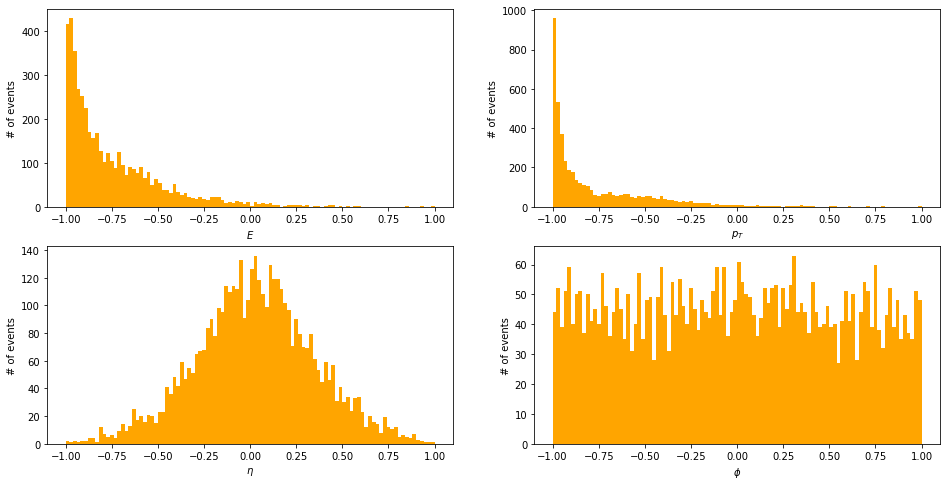

In [7]:
import matplotlib.pyplot as plt

labels = [r'$E$',r'$p_T$', r'$\eta$', r'$\phi$']

n_bins = 100

plt.figure(figsize=(16,8))

for i in range(4):
  plt.subplot(2,2,i+1)
  plt.hist(X_test[:,i],bins=n_bins,color='orange')
  plt.xlabel(xlabel=labels[i])
  plt.ylabel(ylabel='# of events')

## 3. Training and using the Network for compression

If you are running this notebook on Colab, you should run the next cell to install and setup the fastai framework.When prompted with the authorization code, follow the steps enunciated.

In [8]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

First of all, we must set a DataLoader for the mini-batches optmization algorithm.The dls acts like a wraper tha revolves the two 

In [9]:
import fastai
import torch.nn as nn
from torch.autograd import Variable


def load_data(data_arrays, batch_size):
  dataset = torch.utils.data.TensorDataset(*data_arrays)
  return torch.utils.data.DataLoader(dataset,batch_size)



data_iter_train = load_data((X_train,X_train),256)
data_iter_valid = load_data((X_test,X_test),256)

dls = fastai.data.core.DataLoaders(data_iter_train,data_iter_valid)

For the network itself, I will use a deep autoencoder network like the example given in the task, because it performed well in a very similar dataset

This network consists, as any deep autoencoder network, of two halves: a encoder and a decoder half(they does not need to be the same but usually are). 

For the encoding half we'll have 4 input nodes(the 4 kinect features) that are going to pass through 3 fully connected layers of different node sizes.

After this process, our data will have only 3 dimension, and it won't be the 4 features of input, but some more abstract(and compressed) representation of our data.

Now, to see if our network is working properly, we have to decode this 3 dimension into the 4 original features, and compare with the original input. This process of decoding consists of a mirror of encoding in this network.

Between all the layers, there is a tanh activation function.

We can describe our network as:
in-200-200-20-3-20-200-200-out

In [10]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
#model.to('cpu') #if your computer doenst have a gpu

As loss function, we can use Mean Squared Error, as it will compare directly the inputs and outputs that should be similar. We also set a small weight decay(again I picked up this value because it worked well on the example) to prevent the overtfitting of the network

As metric we could also use the Mean Squared Erros, because we just want to see the difference between the input and the output.

In [11]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

wd = 1e-6
recorder = fastai.learner.Recorder()
learn = fastai.learner.Learner(dls,model=model,wd=wd,loss_func=loss_func,cbs=recorder,metrics=loss_func)

Now, we can train the network. To train the network we will use the 1cycle policy, a technique that consists of variable learning rates for each cycle in the range of a maximum learning rate, so we can always choose the best learning rate. 

For our lucky, fastai already has 1cycle police built-in in the method fit_one_cycle and as I have tested, the standart lr_max of the algorithm will provide a great convergence for our dataset.

In [12]:
%%time
learn.fit_one_cycle(n_epoch=100)

epoch,train_loss,valid_loss,None,time
0,0.233540,0.147225,0.147225,00:01
0,0.233540,0.147225,0.147225,00:01
1,0.144104,0.113643,0.113643,00:01
1,0.144104,0.113643,0.113643,00:01
2,0.079422,0.048744,0.048744,00:01
2,0.079422,0.048744,0.048744,00:01
3,0.039411,0.022070,0.022070,00:01
3,0.039411,0.022070,0.022070,00:01
4,0.015837,0.009254,0.009254,00:01
4,0.015837,0.009254,0.009254,00:01


CPU times: user 1min 52s, sys: 1.05 s, total: 1min 53s
Wall time: 1min 56s


If we plot the loss function over training iteration we could see that the network have hit a plateau and there are no signs of overfitting(the valid loss does not increase as the train loss decreases).

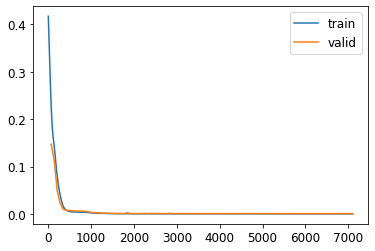

In [13]:
recorder.plot_loss()

In [14]:
print(learn.validate())
output = model(X_test)

[0.0006674847682006657, 0.000667484593577683]


We can plot the output and the input togheter to see how much our results ressamble the input. We can reescale the variables to the original ranges so it represents the physical values.

In [15]:
X_test[:,0] = normalize(X_test[:,0],tE_min,tE_max)
X_test[:,1] = normalize(X_test[:,1],tpt_min,tpt_max)
X_test[:,2] = normalize(X_test[:,2],teta_min,teta_max)
X_test[:,3] = normalize(X_test[:,3],tphi_min,tphi_max)

output[:,0] = normalize(output[:,0],E_min,E_max)
output[:,1] = normalize(output[:,1],pt_min,pt_max)
output[:,2] = normalize(output[:,2],eta_min,eta_max)
output[:,3] = normalize(output[:,3],phi_min,phi_max)

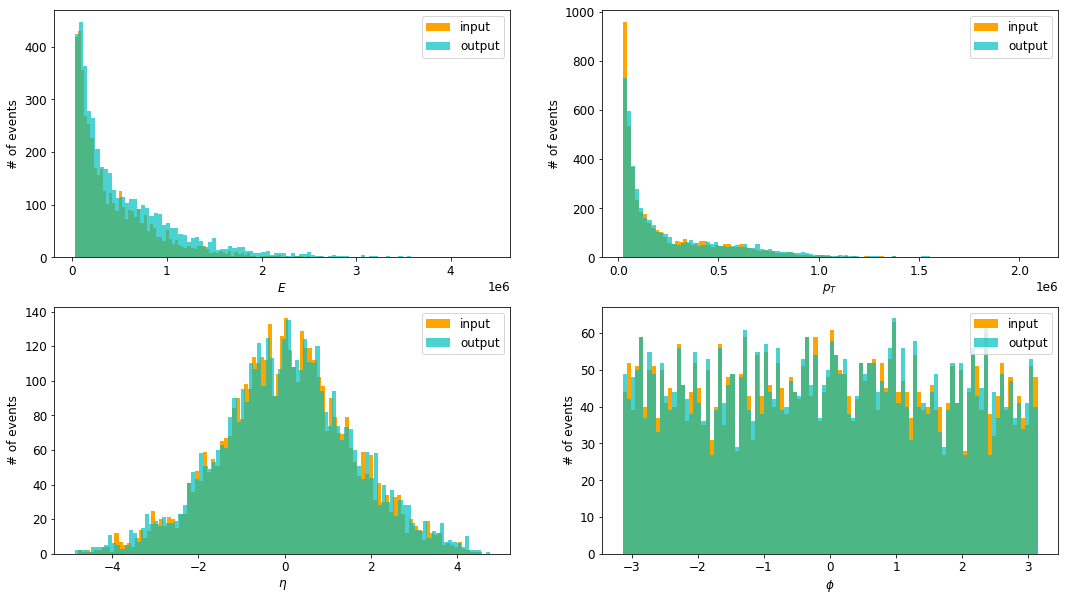

In [16]:


labels = [r'$E$',r'$p_T$', r'$\eta$', r'$\phi$']

n_bins = 100

plt.figure(figsize=(18,10))

for i in range(4):
  plt.subplot(2,2,i+1)
  plt.hist(X_test[:,i],bins=n_bins,color='orange',alpha=1,label='input')
  plt.hist(output.detach().numpy()[:,i],bins=n_bins,color='c',alpha=0.7, label='output')
  plt.xlabel(xlabel=labels[i])
  #plt.yscale('log')
  plt.ylabel(ylabel='# of events')
  plt.legend()

As it is possible to see, the output data has a very similar format to the input data.

This fact summed up with the low MSE, lead us to conclude that the present network works very well for the given task.